In [1]:
import os
import shutil
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms

In [3]:
#loading in the data\
DATA_PATH = "../Data/flowers/"
data_files = os.listdir(DATA_PATH)
dict_ = {}
cn = 0
for file in data_files:
    if file.split("_")[0] not in dict_:
        dict_[file.split("_")[0]] = 1
        cn += 1
    else:
        dict_[file.split("_")[0]] += 1
print(f"We have {cn} different kinds of flowers")
print(dict_)

We have 10 different kinds of flowers
{'lilies': 81, 'hibiscus': 74, 'orchids': 64, 'bougainvillea': 74, 'garden': 74, 'daisies': 83, 'hydrangeas': 60, 'peonies': 75, 'tulip': 71, 'gardenias': 77}


In [4]:
try:
    os.mkdir("train_data")
except FileExistsError:
    print("Folder already exisits")

Folder already exisits


In [5]:
#creating folders for our data


In [6]:
#copying file to relevant folders
for file in data_files:
    file_split_name = file.split("_")[0]
    if file_split_name in dict_:
        try:
            shutil.copy(f"{DATA_PATH}/{file}", f"train_data/{file_split_name}")
        except FileExistsError:
            continue

In [7]:
#data transformation pipe line
transform  = transforms.Compose([
 
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [8]:
dataset = ImageFolder("./train_data/", transform = transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle = True)

In [9]:
dataloader.dataset.classes

['bougainvillea',
 'daisies',
 'garden',
 'gardenias',
 'hibiscus',
 'hydrangeas',
 'lilies',
 'orchids',
 'peonies',
 'tulip']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


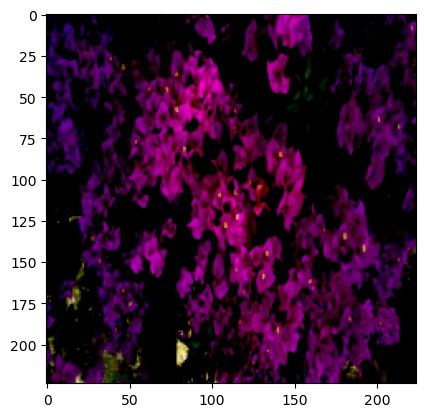

In [10]:
plt.imshow(dataloader.dataset[0][0].permute(2,1,0))

In [11]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        shortcut = self.shortcut(x)
        out = self.block(x)
        out += shortcut
        return nn.ReLU(inplace=True)(out)

In [12]:
class ResNet(nn.Module):
    def __init__(self, num_classes=10):  # Output classes for classification
        super(ResNet, self).__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.ResidualBlock64 = nn.Sequential(
            ResidualBlock(64, 64),
            ResidualBlock(64, 64),
            ResidualBlock(64, 64),
        )

        self.ResidualBlock128 = nn.Sequential(
            ResidualBlock(64, 128, stride=2),  # Downsample
            ResidualBlock(128, 128),
            ResidualBlock(128, 128),
        )

        self.ResidualBlock256 = nn.Sequential(
            ResidualBlock(128, 256, stride=2),
            ResidualBlock(256, 256),
            ResidualBlock(256, 256),
            ResidualBlock(256, 256),
            ResidualBlock(256, 256),
            ResidualBlock(256, 256),
        )

        self.ResidualBlock512 = nn.Sequential(
            ResidualBlock(256, 512, stride=2),
            ResidualBlock(512, 512),
            ResidualBlock(512, 512),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes) 

    def forward(self, x):
        x = self.block1(x)
        x = self.ResidualBlock64(x)
        x = self.ResidualBlock128(x)
        x = self.ResidualBlock256(x)
        x = self.ResidualBlock512(x)

        x = self.avgpool(x)  # Global Pooling
        x = torch.flatten(x, 1)  # Flatten before FC layer
        x = self.fc(x)  # Classification Output

        return x

In [13]:
resnet = ResNet()

In [14]:
resnet

ResNet(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (ResidualBlock64): Sequential(
    (0): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      

In [15]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

In [16]:
resnet.to(device)

ResNet(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (ResidualBlock64): Sequential(
    (0): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      

In [17]:
#train loop
optimizer = optim.SGD(resnet.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()

In [18]:
epochs = 15
for i in range(epochs):
    epoch_loss = 0
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        output = resnet(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {i} loss is: {epoch_loss/len(dataloader)}")

Epoch 0 loss is: 2.350367181974909
Epoch 1 loss is: 1.9752909644790317
Epoch 2 loss is: 1.7570320970338325
Epoch 3 loss is: 1.5454601982365483
Epoch 4 loss is: 1.4156169862202976
Epoch 5 loss is: 1.2978430821195892
Epoch 6 loss is: 1.1942068918243698
Epoch 7 loss is: 1.067351621778115
Epoch 8 loss is: 0.9353602998282599
Epoch 9 loss is: 0.7640688250894132
Epoch 10 loss is: 0.587414791483594
Epoch 11 loss is: 0.443909578592233
Epoch 12 loss is: 0.41663671430686244
Epoch 13 loss is: 0.3712033668694937
Epoch 14 loss is: 0.2583832993151863
